In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
train_path = "masked_data/training"
validation_path = "original_data/validation"
test_path = "original_data/test"

In [3]:
dimentions = (299, 299)
batch_size = 64

n_class = 2

In [4]:
train_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [5]:
valid_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 710 images belonging to 2 classes.


In [7]:
validation_generator = valid_datagen.flow_from_directory(
    validation_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [8]:
test_generator = valid_datagen.flow_from_directory(
    test_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from keras.models import Model

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
)

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
predictions = Dense(n_class, activation='softmax')(x)    
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
from keras import metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
from keras.callbacks import ModelCheckpoint  

# !mkdir saved_models

model_file = 'saved_models/cropped_weights.best.InceptionV3.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [12]:
epochs = 10

In [13]:
train_history = model.fit_generator(train_generator, 
                                    validation_data=validation_generator, 
                                    epochs=epochs, 
                                    callbacks=[checkpointer],
                                    steps_per_epoch=train_generator.samples // batch_size, 
                                    validation_steps=validation_generator.samples // batch_size
                                   )

Epoch 1/10
11/11 [==============================] - 56s 5s/step - loss: 0.4063 - acc: 0.8409 - val_loss: 8.1865 - val_acc: 0.3385

Epoch 00001: val_loss improved from inf to 8.18646, saving model to saved_models/cropped_weights.best.InceptionV3.hdf5
Epoch 2/10
11/11 [==============================] - 27s 2s/step - loss: 0.2062 - acc: 0.9259 - val_loss: 4.7747 - val_acc: 0.5771

Epoch 00002: val_loss improved from 8.18646 to 4.77473, saving model to saved_models/cropped_weights.best.InceptionV3.hdf5
Epoch 3/10
11/11 [==============================] - 23s 2s/step - loss: 0.1434 - acc: 0.9244 - val_loss: 7.4566 - val_acc: 0.3657

Epoch 00003: val_loss did not improve from 4.77473
Epoch 4/10
11/11 [==============================] - 23s 2s/step - loss: 0.1106 - acc: 0.9571 - val_loss: 2.8673 - val_acc: 0.8171

Epoch 00004: val_loss improved from 4.77473 to 2.86730, saving model to saved_models/cropped_weights.best.InceptionV3.hdf5
Epoch 5/10
11/11 [==============================] - 23s 2s/s

In [14]:
train_history.history

{'val_loss': [8.186458110809326,
  4.774726363590785,
  7.456576886858259,
  2.867302348273141,
  3.1297077337900796,
  10.458228073120118,
  9.814167894635881,
  13.118977176121303,
  2.350558042526245,
  4.252505828312465],
 'val_acc': [0.3385416666666667,
  0.5771428554398673,
  0.36571428213800705,
  0.8171428619112288,
  0.25,
  0.15999999923365457,
  0.2571428576537541,
  0.1771428577389036,
  0.8541666666666666,
  0.3085714270387377],
 'loss': [0.40628046881068836,
  0.2081605461267495,
  0.13607072834813558,
  0.11914620097386348,
  0.08881764409951173,
  0.06373857516483995,
  0.02764275832788053,
  0.08368387329320051,
  0.16302304481943325,
  0.17420502425670253],
 'acc': [0.8409090909090909,
  0.9334365323232054,
  0.9318885447071064,
  0.9535603715170279,
  0.9613003095975232,
  0.9845201238390093,
  0.9907120743034056,
  0.967492259877385,
  0.9489164084841961,
  0.9396284829721362]}

In [15]:
import matplotlib.pyplot as plt

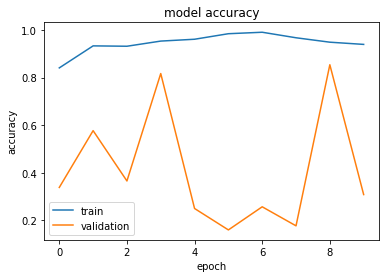

In [16]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

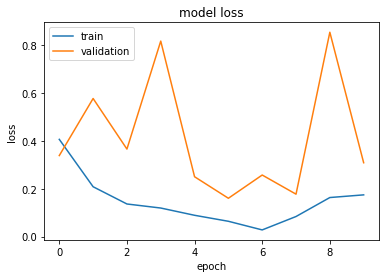

In [17]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
model.load_weights(model_file)
tesr_result = model.evaluate_generator(test_generator, steps=10)

In [19]:
tesr_result

[3.0146148133986066, 0.8102310266431803]

In [20]:
predict = model.predict_generator(test_generator,steps = 10)

In [21]:
import cv2
import numpy as np


from keras.preprocessing import image
# img = cv2.imread(path_to_one_file)
# img = np.array([img]).reshape((1, 3, 299, 299))

def to_tensor(img_path): 
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    
    return img_tensor

In [22]:
def make_predict(img_path): 
    class_dic = {}
    for k, v in test_generator.class_indices.items():
        class_dic[v] = k
    
    
    y_prob = model.predict(to_tensor(img_path))
    y_classes = y_prob.argmax(axis=-1)
    return class_dic[y_classes[0]]

In [23]:
img_path = "original_data/test/benign/ISIC_0004472.jpg"
make_predict(img_path)

'benign'

In [24]:
class_dic = dict(test_generator.class_indices)
print(class_dic)

one_hot = {}
for k, v in test_generator.class_indices.items():
    one_hot[v] = k
print(one_hot)

{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


In [25]:
from os import listdir 

y_true = [] 
y_pred = []

class_name = "benign"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    
class_name = "malignant"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    

In [26]:
len(y_true) == len(y_pred)

True

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["benign", "malignant"])

In [28]:
import pandas as pd
df_cm = pd.DataFrame(cm, ["benign", "malignant"], ["benign", "malignant"])

In [29]:
import seaborn as sn

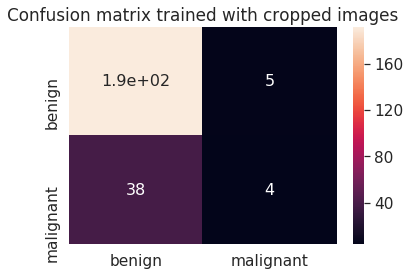

In [30]:
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("Confusion matrix trained with cropped images")# font size
plt.show()

In [31]:
from sklearn.metrics import f1_score
y_true_01 = [class_dic[p] for p in y_true]
y_pred_01 = [class_dic[p] for p in y_pred]
f1_score(y_true_01, y_pred_01)

0.1568627450980392

In [32]:
from sklearn.metrics import recall_score
recall_score(y_true_01, y_pred_01) 

0.09523809523809523

In [33]:
from sklearn.metrics import precision_score
precision_score(y_true_01, y_pred_01) 

0.4444444444444444

In [36]:
# y_pred_01